In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use(['ggplot', 'assets/class.mplstyle'])

red = '#E24A33'
blue = '#348ABD'
purple = '#988ED5'
gray = '#777777'
yellow = '#FBC15E'
green = '#8EBA42'
pink = '#FFB5B8'

# Common Statistical Distributions in Astronomy

We have already explored the classical treatment of the gaussian distribution. Let's now look at other probability distributions that arise in typical astronomical calculations.

## 1. The Binomial Distribuition

*Counting Problems.*

An experiment has two possible outcomes, generally thought of as *success* or *failure*. Say the probability of success is $\rho$. If you make the experiment $N$ times, what is the chance of getting $n$ *successes*?:

$$ p(n) = {N\choose n} \rho^n (1-\rho)^{N-n} $$

Obviously this distribution takes discrete values. The mean and variance of the RV $n$ is calculated as:

$$ E(n) = \sum_{n=0}^N n p(n) = N \times \rho \\
Var(n) = \sum_{n=0}^N (n-N\rho)^2 p(n) = N \rho (1-\rho)$$

In [2]:
from scipy.stats import binom

N = 20
rho = 0.275

binomial_rv = binom(N, rho)

We can look at its moments:

In [3]:
E, V, S, K = binomial_rv.stats(moments='mvsk')
print('E(x)={}, Var(x)={}, Sigma(x)={:.3f}, K(x)={:.3f}'.format(E, V, S, K))

E(x)=5.5, Var(x)=3.9875, Sigma(x)=0.225, K(x)=-0.049


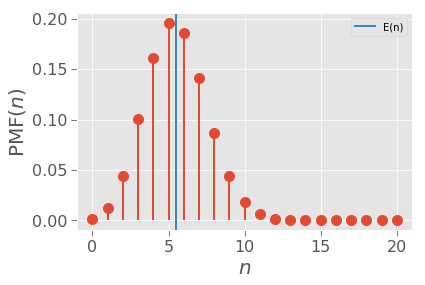

In [4]:
n_to_plot = np.arange(N+1)

plt.plot(n_to_plot, binomial_rv.pmf(n_to_plot), color=red, ls='None', 
         marker='o')
plt.vlines(n_to_plot, binomial_rv.pmf(n_to_plot), 0, color=red)

mean = N * rho
plt.axvline(mean, color=blue, label="E(n)")

plt.xlabel('$n$')
plt.ylabel('PMF($n$)')

_= plt.legend()

---
### Example 2

We have studied a sample of 60 globular clusters and found that 10 of them have a black hole in their center. We want to know more about black holes in globular clusters so we design a new survey. We will study 20 globular clusters. In our proposal we must place a constrain on the number of new Black Holes we expect to find. For example, what is the chance we will find 10 or more BHs among our 20 GCs?

### Solution

If we assume that our original sample is representative, then we can say that $\rho=10/60$. With that, we can calculate the PMF.

In [5]:
N = 20
rho = 10 / 60

bh_rv = binom(N, rho)

Text(0,0.5,'BH PMF($n$)')

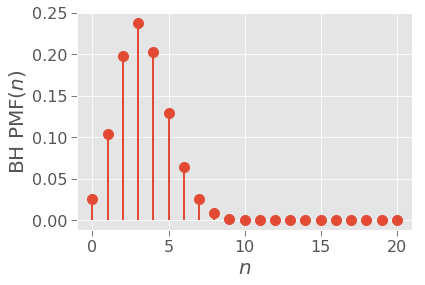

In [6]:
n_to_plot = np.arange(N+1)

plt.plot(n_to_plot, bh_rv.pmf(n_to_plot), color=red, ls='None', 
         marker='o')
plt.vlines(n_to_plot, bh_rv.pmf(n_to_plot), 0, color=red)

plt.xlabel('$n$')
plt.ylabel('BH PMF($n$)')

In [7]:
chance_of_10_to_20 = bh_rv.pmf(range(10, 21))
chance_of_10plus = np.sum(chance_of_10_to_20)

print("The chance of finding 10 BHs among 20 GCs is: {:.3f}%".format(100*chance_of_10plus))

The chance of finding 10 BHs among 20 GCs is: 0.060%


---

## 2. The Poisson Distribuition

*Photons in a detector.*

In the limiting case of a Binomial Distribution, when $\rho\to0$ (very small chance) but $E(n)=(N\times\rho)\to \mu$, some finite value, the expression for the Binomial Distribution PMF approaches the expression:

$$ p(n) = \frac{\mu^n}{n!}e^{-\mu} $$

which is the PMF for the Poisson Distribution. The mean and variance of the Possion distribution are both $\mu$:

$$ E(n) = Var(n) = \mu $$



In [13]:
from scipy.stats import poisson

mu = 3.
poisson_rv = poisson(mu)

In [14]:
E, V, S, K = poisson_rv.stats(moments='mvsk')
print('E(x)={}, Var(x)={}, Sigma(x)={:.3f}, K(x)={:.3f}'.format(E, V, S, K))

E(x)=3.0, Var(x)=3.0, Sigma(x)=0.577, K(x)=0.333


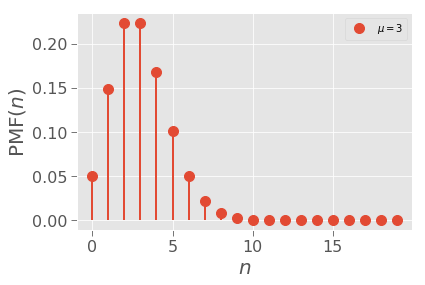

In [17]:
N_max = 100
n_to_plot = np.arange(N)

plt.plot(n_to_plot, poisson_rv.pmf(n_to_plot), color=red, ls='None', 
         marker='o', label='$\mu=3$')
plt.vlines(n_to_plot, poisson_rv.pmf(n_to_plot), 0, color=red)

plt.xlabel('$n$')
plt.ylabel('PMF($n$)')

_= plt.legend()

---
### Example 3

The chances of a given photon arriving to a detector during an interval of time is small (that is, $\rho$ is small for the Binomial). But there are many photons so on average we get $\mu$ photons per interval. The arrivals of successive photons are also independent (roughly speaking).


